# Fairness Benchmark

This notebook plots the suboptimality performance of various optimization algorithms against demographic/statistical parity on the Diabetes 130-Hospitals (`diabetes`) and Adult Census (`acsincome`) benchmarks.

In [4]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.io import get_path, var_to_str, load_results
from src.utils.data import load_dataset

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
from tqdm import tqdm

In [15]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
l2_reg = 1.0
shift_cost = 1.0

In [9]:
# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8, 16, 1024]
batch_sizes = [32, 64, 128]

# Function to generate result directories
def generate_result_dirs(base_path, epsilon_values, batch_sizes):
    result_dirs = []
    for epsilon in epsilon_values:
        for batch_size in batch_sizes:
            result_dir = f"{base_path}\\results_{epsilon:.6f}_{batch_size}"
            result_dirs.append(result_dir)
    return result_dirs

# Base path to the experiments folder
base_path = "C:\\PrivacyInAI\\code\\prospect\\experiments"

# Generate the result directories
result_dirs = generate_result_dirs(base_path, epsilon_values, batch_sizes)

# Print the result directories as strings
for dir in result_dirs:
    print(f'"{dir}"')

"C:\PrivacyInAI\code\prospect\experiments\results_2.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_2.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_2.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_4.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_4.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_4.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_8.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_8.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_8.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_16.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_16.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_16.000000_128"
"C:\PrivacyInAI\code\prospect\experiments\results_1024.000000_32"
"C:\PrivacyInAI\code\prospect\experiments\results_1024.000000_64"
"C:\PrivacyInAI\code\prospect\experiments\results_1024.000000_128"


In [11]:
plot_cfgs = [
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD",
        "color": "pink",
        "linestyle": "solid",
        "marker": "^",
    },
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },

    # {
    #     "optimizer": "saddlesaga",
    #     "label": "SaddleSAGA",
    #     "color": "goldenrod",
    #     "linestyle": "solid",
    #     "marker": "s",
    # },
    {
        "optimizer": "lsvrg",
        "label": "LSVRG",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
    # {
    #     "optimizer": "prospect",
    #     "label": "Prospect (Ours)",
    #     "color": "tab:red",
    #     "linestyle": "solid",
    #     "marker": "^",
    # },
]

In [22]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def get_iterates(dataset, objective, optimizer, seed=1, result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results"):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        "n_class": None,
        "shift_cost": shift_cost
    }
    print(optimizer)
    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
    f = os.path.join(path, f"iterates_{seed}.p")
    return [iterate.detach() for iterate in pickle.load(open(f, "rb"))]

def get_dp(column, optimizer, objective, metric="difference", result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results"):
    iterates = get_iterates(dataset, objective, optimizer, result_dir=result_dir)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        print(X.shape)
        print(w.shape)
        print(w)
        y_pred = (X @ w >= 0).int()
        if metric == "difference":
            out.append(demographic_parity_difference(y, y_pred, sensitive_features=list(df[column])))
        elif metric == "ratio":
            out.append(demographic_parity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

def get_ks_dist(y_pred, y_true):
    out = ks_2samp(y_pred, y_true, method="asymp")
    return out.statistic

def get_dist_groups(column, optimizer, objective, dataset="acsincome", method="ks", result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results"):
    iterates = get_iterates(dataset, objective, optimizer, result_dir=result_dir)
    groups = list(df[column].unique())

    dist_groups = []

    for i, w in tqdm(enumerate(iterates)):
        y_pred = (X @ w).numpy()
        ypd = pd.Series(y_pred)
        y_groups = [(ypd.loc[df[column] == group]).to_numpy() for group in groups]
        if method == "ks":
            dist_groups.append(np.array([get_ks_dist(y_pred, y_group) for y_group in y_groups]))
        elif method == "wasserstein":
            dist_groups.append(np.array([wasserstein_dist(y_pred, y_group) for y_group in y_groups]))

    return np.array(dist_groups)

def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=1, max_epoch=32, markersize=8, out_path="../results/", result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
        "n_class": None,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=result_dir
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )

torch.Size([1000, 31])
torch.Size([1000])
['Female' 'Male']
['Hispanic' 'Caucasian' 'AfricanAmerican' 'Unknown' 'Asian' 'Other']
torch.Size([1000, 202])
torch.Size([1000])
[1. 2.]
[1. 2. 9. 8. 7. 6. 5. 3.]


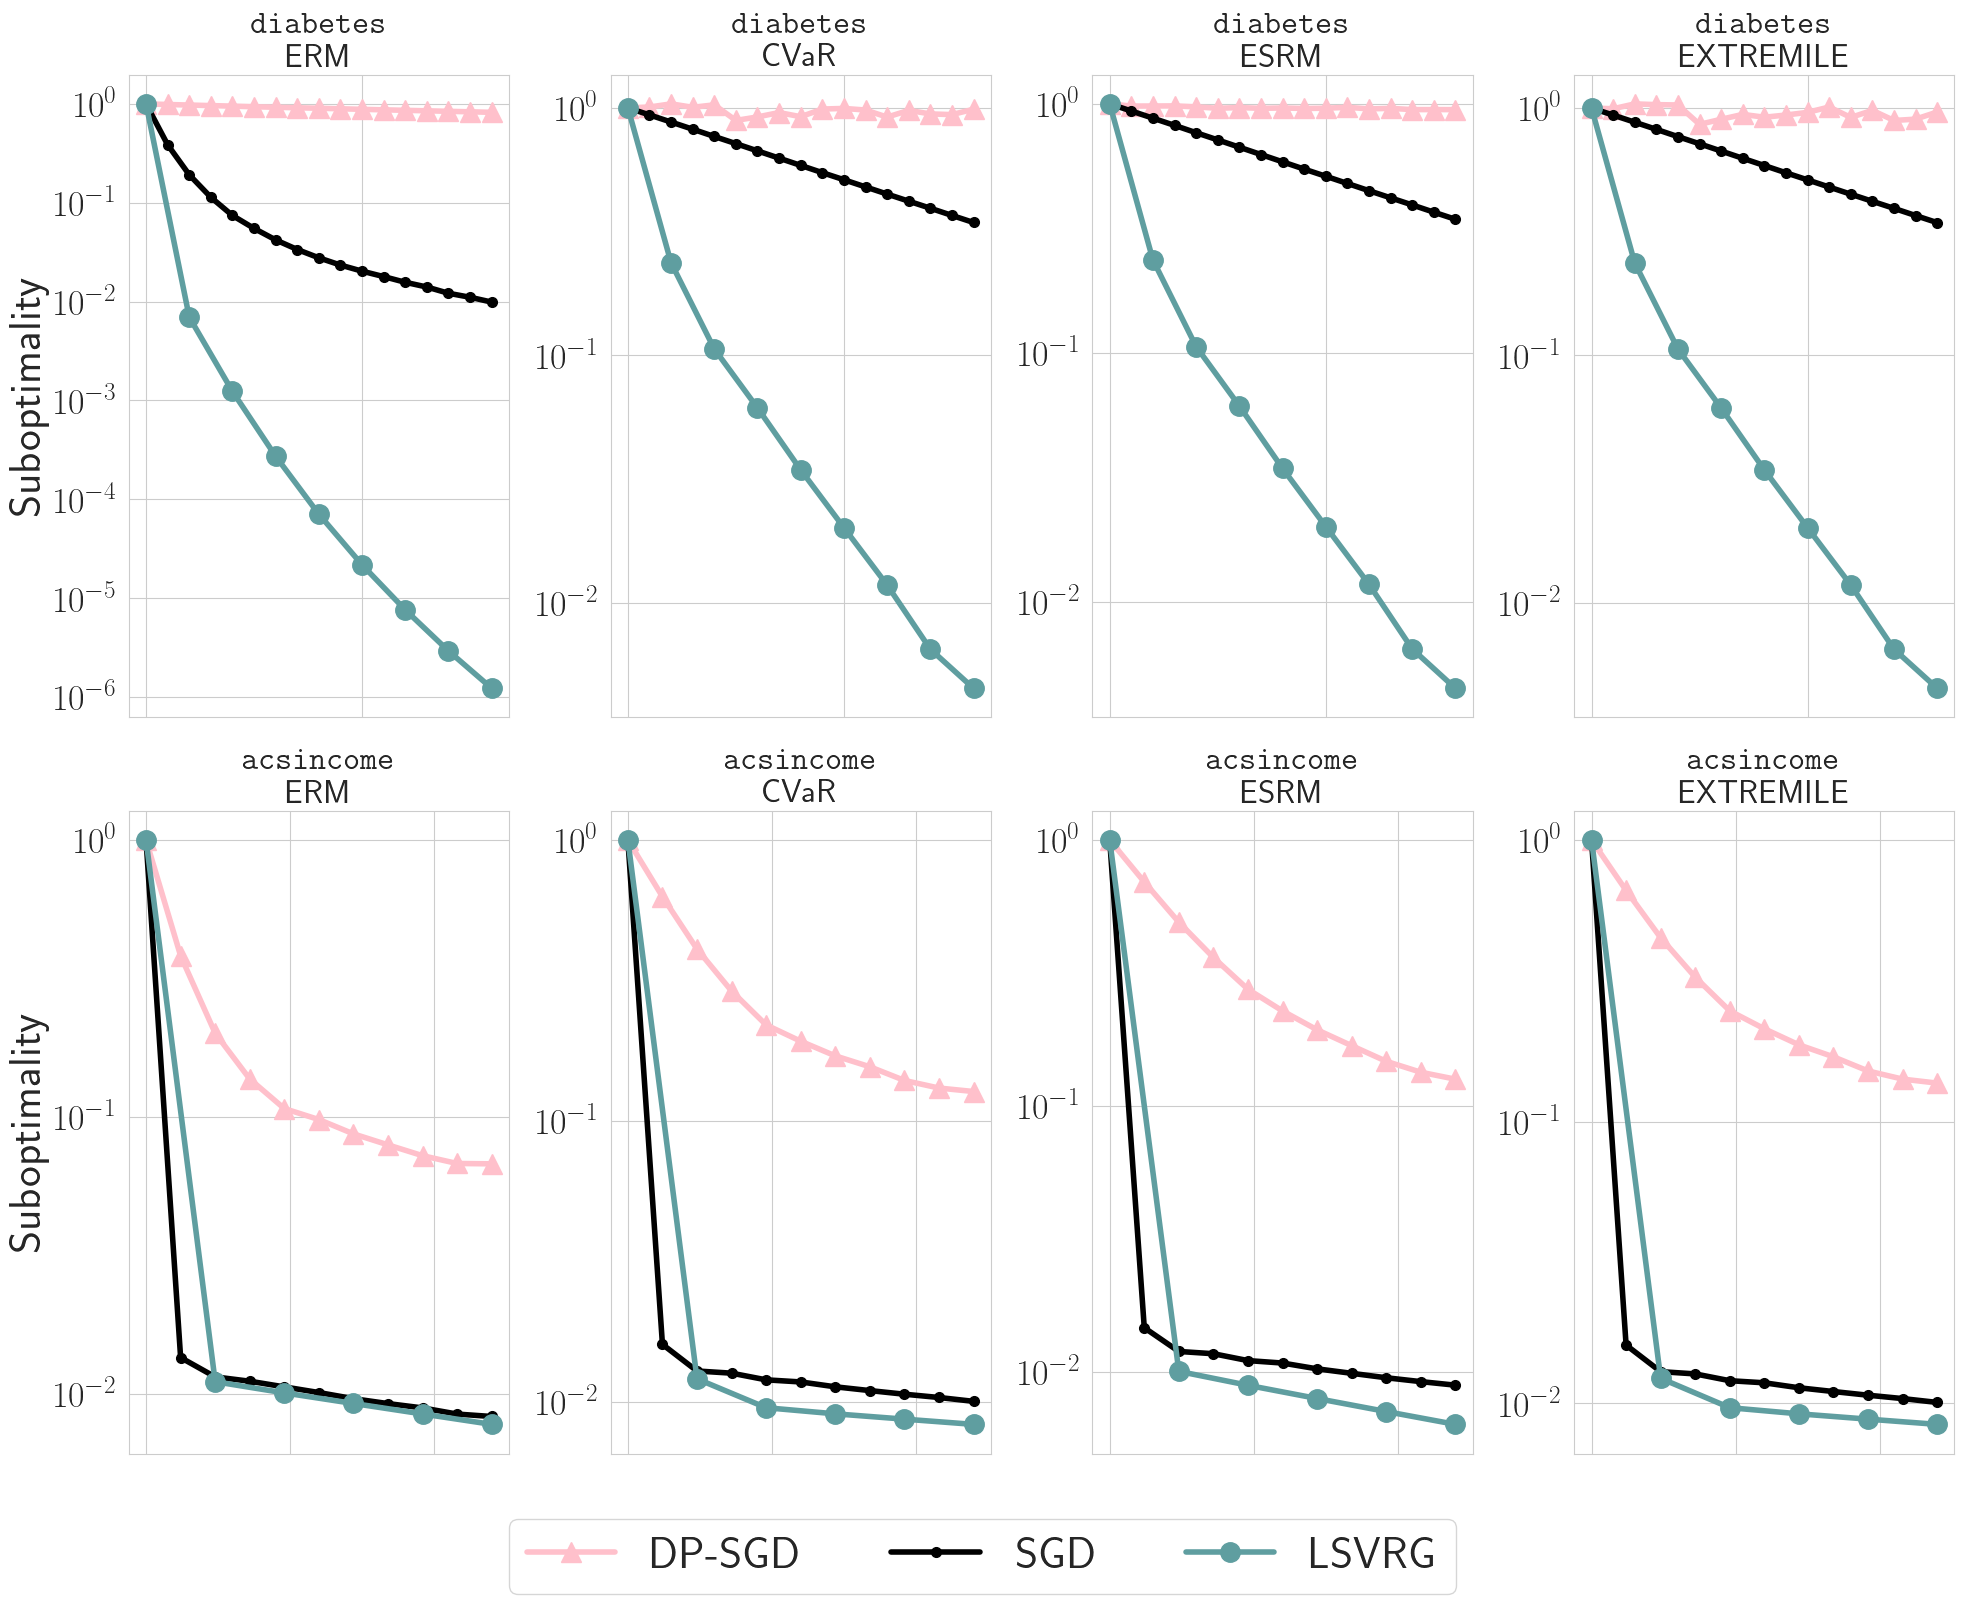

In [ ]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Load diabetes dataset
dataset = "diabetes"
X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

print(X.shape)
print(y.shape)
df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")

print(df.gender.unique())
print(df.race.unique())

objectives = ["erm", "superquantile", "esrm", "extremile"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

# Create enough subplots for both datasets
fig, ax = plt.subplots(2, len(objectives), figsize=(20, 15))  # 2 rows for the two datasets

obj_names = ["ERM", "CVaR", "ESRM", "EXTREMILE"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]

        markersize = 14
        downsample = 2

        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])

ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)

# Load acsincome dataset
dataset = "acsincome"
X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")
print(df.SEX.unique())
print(df.RAC1P.unique())

column = "RAC1P"

for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]

        markersize = 14
        downsample = 6
        ax[1, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)

        plot_ax(ax[1, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize)
        ax[1, j].set_yscale("log")
        ax[1, j].set_xticklabels([])

ax[1, 0].set_ylabel(f"Suboptimality", fontsize=32)

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Save each subplot as a separate PNG file
for i in range(2):
    for j in range(len(objectives)):
        extent = ax[i, j].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f"../figures/subplot_{i}_{j}.png", bbox_inches=extent)

plt.show()

In [25]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8, 16, 1024]
batch_sizes = [32, 64, 128]
'''
# Load diabetes dataset
dataset = "diabetes"
X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")
print(df.gender.unique())
print(df.race.unique())

objectives = ["erm", "superquantile", "esrm", "extremile"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

# Create enough subplots for both datasets
fig, ax = plt.subplots(2, len(objectives), figsize=(12, 10))  # 2 rows for the two datasets

obj_names = ["ERM", "CVaR", "ESRM", "EXTREMILE"]

# Iterate through batch sizes and epsilon values for diabetes dataset
for j, objective in enumerate(objectives):
    for epsilon in epsilon_values:
        for batch_size in batch_sizes:
            plot_cfg = {"optimizer": "sgd"}  # Only using SGD optimizer
            markersize = 14
            downsample = 2

            ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

            # Construct the result directory path for the current epsilon and batch size
            result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
            
            # Call the plotting function for the current configuration
            plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize, result_dir=result_dir)
            ax[0, j].set_yscale("log")
            ax[0, j].set_xticklabels([])

ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)
'''
# Load acsincome dataset
dataset = "acsincome"
X = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\X_test.npy"))
y = torch.tensor(np.load(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\y_test.npy")).double()

print(X.shape)
print(y.shape)

df = pd.read_csv(f"C:\\PrivacyInAI\\code\\prospect\\data\\{dataset}\\metadata_te.csv")
print(df.SEX.unique())
print(df.RAC1P.unique())

column = "RAC1P"

# Iterate through batch sizes and epsilon values for acsincome dataset
for j, objective in enumerate(objectives):
    for epsilon in epsilon_values:
        for batch_size in batch_sizes:
            optimizer = plot_cfg["optimizer"]  # Only using SGD optimizer
            markersize = 14
            downsample = 6

            ax[1, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)

            # Construct the result directory path for the current epsilon and batch size
            result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"

            # Call the plotting function for the current configuration
            plot_ax(ax[1, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize, result_dir=result_dir)
            ax[1, j].set_yscale("log")
            ax[1, j].set_xticklabels([])

ax[1, 0].set_ylabel(f"Suboptimality", fontsize=32)

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

torch.Size([1000, 202])
torch.Size([1000])
[1. 2.]
[1. 2. 9. 8. 7. 6. 5. 3.]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\PrivacyInAI\\code\\prospect\\experiments\\results_2.000000_32\\acsincome/l2_reg_1.00e+00_loss_squared_error_objective_erm_shift_cost_1.00e+00/lbfgs_min_loss.p'